# Data Analysis Interview Challenge

### By Silas Lee

## Part 1 ‐ Exploratory data analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import json

### Read login times json file

In [2]:
loginsdf = pd.read_json('logins.json')
print(loginsdf.info())
loginsdf.set_index('login_time', inplace=True)
loginsdf.index = pd.to_datetime(loginsdf.index)
display(loginsdf.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


""
login_time
1970-01-01 20:13:18
1970-01-01 20:16:10
1970-01-01 20:16:37
1970-01-01 20:16:36
1970-01-01 20:26:21


###  Aggregate these login counts based on 15 minute time intervals

In [3]:
loginsdf['count'] = ""
logins = loginsdf.resample("15T").count()

display(logins.head())

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


### Find average number of logins per day

In [4]:
daycount = loginsdf.resample("1D").count()
display(daycount.head())

,count
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [5]:
daymean = logins.resample('1D').mean()
display(daymean.head())

,count
login_time,
1970-01-01,7.000000
1970-01-02,7.093750
1970-01-03,8.260417
1970-01-04,8.208333
1970-01-05,4.781250


Text(0.5,0,'Login Time')

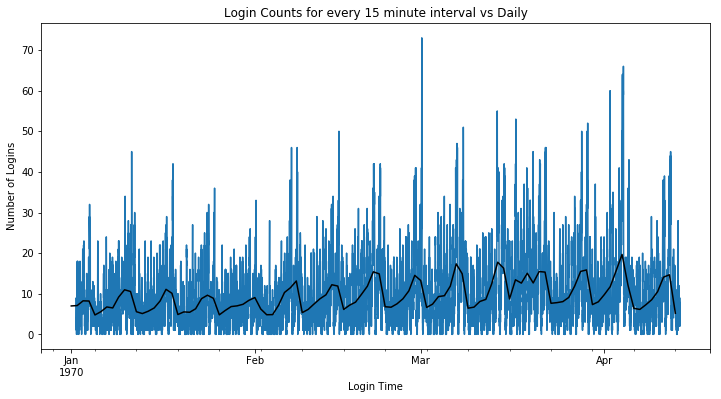

In [6]:
plt.figure(figsize=(12,6))
logins['count'].plot()
daymean['count'].plot(color='black', linewidth = 1.5)
plt.title('Login Counts for every 15 minute interval vs Daily')
plt.ylabel('Number of Logins')
plt.xlabel('Login Time')

### Find busiest times

In [7]:
sorted = logins.sort_values(by=['count', 'login_time'])
display(sorted.tail(10))

,count
login_time,
1970-03-13 22:15:00,55
1970-04-04 01:45:00,56
1970-04-04 04:45:00,59
1970-04-04 05:15:00,59
1970-04-01 23:30:00,60
1970-04-04 05:00:00,60
1970-04-04 01:15:00,63
1970-04-04 01:30:00,64
1970-04-04 05:30:00,66


### Find Average Number of Logins based on Day of the Week

In [8]:
import calendar
daycount['day'] = daycount.index
daycount['day_of_week'] = daycount['day'].apply(lambda x: x.weekday()) # get the weekday index, between 0 and 6
daycount['day_of_week'] = daycount['day_of_week'].apply(lambda x: calendar.day_name[x])

In [9]:
daycountw = daycount.groupby('day_of_week').mean()
daycountw['day'] = daycountw.index
daycountw

,count,day
day_of_week,,
Friday,1013.866667,Friday
Monday,588.200000,Monday
Saturday,1291.800000,Saturday
Sunday,1211.133333,Sunday
Thursday,797.333333,Thursday
Tuesday,662.000000,Tuesday
Wednesday,738.500000,Wednesday


Text(0.5,1,'Average Login Count by Day of Week')

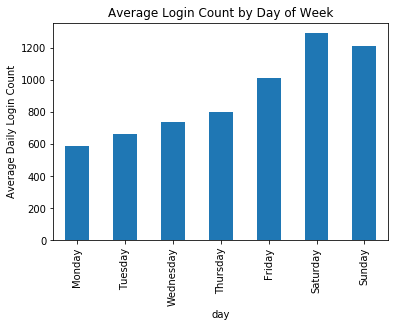

In [10]:
# Create bar graph by weekday
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
ax = daycountw.set_index("day").loc[day_order].plot(kind="bar", legend=False)
ax.set_ylabel("Average Daily Login Count")
ax.set_title("Average Login Count by Day of Week")

### Find Average Number of Logins based on Time of Day

In [11]:
loginshour = logins.copy()
loginshour['login_time'] = loginshour.index
loginshour['hour'] = loginshour[
    'login_time'].dt.hour
hours = loginshour
hour = hours[['count', 'hour']]
hour = hour.groupby('hour').sum().reset_index()
hour.head()

,hour,count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


Text(0.5,0,'Hour of day')

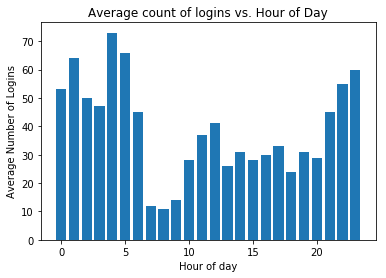

In [12]:
plt.bar(x=loginshour['hour'], height=loginshour['count'])
plt.title('Average count of logins vs. Hour of Day')
plt.ylabel('Average Number of Logins')
plt.xlabel('Hour of day')

### Conclusion: 
Amount of logins are lowest on Mondays and increase through the week with the highest average amount of logins on Saturdays. The most logins are also in early morning, around noon, then late at night with a severe lull between 7-9am. The overall period of most logins occured on March 1st at 4:30am and the remaining of the top 5 periods with the most logins occured on the morning of April 4.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

I would use the number of drivers crossing the bridge during the weekday as the key measure of success. This is making the assumption that this number is being tracked. As weekend activity is similar in Gotham and Metropolis, this activity is not super relevant. Ideally, weekdays will showe an increase of cars entering the bridge from Gotham and weeknights will show an increase of cars entering the bridge from Metropolis, but just a general increase in activity will do.

### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
### a. how you will implement the experiment
### b. what statistical test(s) you will conduct to verify the significance of the observation
### c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.


a. Ideally the current number of drivers using the bridge is already being tracked, but if not then before anything this will need to start. Current activity will be used as the control. As soon as current activity is recorded, announce the plan to reimburse all driver's tolls during the weekdays. In order for the experiment to be acurate, all drivers need to be notified of the reimbursement plan. Both current activity and after toll reimbursements should be tracked for at least 3 months, but ideally a full year to include seasonal patterns.

Ho: There is no difference between the mean number of cars using the bridge.

Ha: There is an increase in the mean number of cars using the bridge after toll reimbursement.

b., c. A one-tailed Z-test would be used to determine the p-value of the hypothesis.
If the p-value is less than 0.05, I would reject the null hypotheses and recommend the reimbursement program continue for longer (up to a year) to gather more data and then be tested again. If there is still no significant increase in driver activity on the bridge, then another alternative should be pursued.

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [13]:
file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Check for datatypes and missing values

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Fill missing ratings of and by drivers with average raings to fill out dataset and convert dates to datetime

In [15]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

Assuming the most recent ride was the day this data was taken, we can find the pull date and calculate the cut off day for the most recent 30 days to determine retention of drivers.

In [16]:
pulldate = df.last_trip_date.max()

cutoff = pulldate - pd.Timedelta('30 days')

# create status for drivers, 0= inactive, 1 = active
df['active_status'] = (df.last_trip_date > cutoff).astype('int')

print("Pull date is: ", pulldate)
print("Cut off date is: ", cutoff)

display(df.head())

Pull date is:  2014-07-01 00:00:00
Cut off date is:  2014-06-01 00:00:00


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_status
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [17]:
# add dummies to categorical data
df1 = pd.get_dummies(df, columns = ['city', 'phone'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 16 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null datetime64[ns]
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
active_status             50000 non-null int64
city_Astapor              50000 non-null uint8
city_King's Landing       50000 non-null uint8
city_Winterfell           50000 non-null uint8
phone_Android             50000 non-null uint8
phone_iPhone              50000 non-null uint8
dtypes: bool(1), datetime64[ns](2), float64(6), int64(2), uint8(5)
memory usage: 4.1 MB


In [18]:
display(df.groupby('active_status').mean())

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
active_status,,,,,,,,
0,6.188478,4.786830,4.605889,1.075367,8.688548,1.659167,0.299621,60.181597
1,5.118977,4.763149,4.594066,1.073720,9.128165,3.349590,0.511141,62.214604


Text(0.5,1,'Distance vs. City')

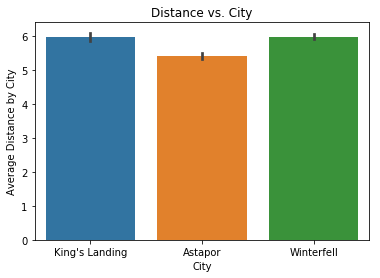

In [21]:
import seaborn as sns
sns.barplot(x='city', y='avg_dist', data=df)
plt.ylabel('Average Distance by City')
plt.xlabel('City')
plt.title('Distance vs. City')

In [22]:
print(df1['active_status'].value_counts())
print(df1['active_status'].sum()/len(df))

0    31690
1    18310
Name: active_status, dtype: int64
0.3662


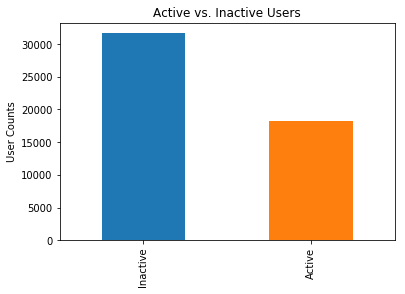

In [23]:
df1.active_status.value_counts().plot(kind='bar')
plt.xticks(range(2), ('Inactive', 'Active'))
plt.ylabel("User Counts")
plt.title("Active vs. Inactive Users")
plt.show()

36.6 Percent of drivers who signed up in January are still active

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [24]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import metrics 
from sklearn.metrics import classification_report

from sklearn.metrics import accuracy_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [25]:
df2 = df1.copy()
df2.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_status,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
avg_dist,1.000000,0.079793,0.028508,-0.081491,-0.104414,-0.136329,0.032310,0.101652,-0.090279,-0.045431,0.015877,0.030050,0.020888,-0.020888
avg_rating_by_driver,0.079793,1.000000,0.101660,0.010498,0.019964,-0.039097,0.009328,0.020366,-0.025595,0.032518,0.084480,-0.098727,0.008765,-0.008765
avg_rating_of_driver,0.028508,0.101660,1.000000,-0.021653,-0.003290,-0.011060,-0.001916,0.012587,-0.010082,0.029814,0.082156,-0.094304,0.024206,-0.024206
avg_surge,-0.081491,0.010498,-0.021653,1.000000,0.793582,-0.001841,-0.078791,-0.110071,-0.003567,0.037172,-0.009198,-0.027643,-0.008977,0.008977
surge_pct,-0.104414,0.019964,-0.003290,0.793582,1.000000,0.005720,-0.106861,-0.144918,0.010612,0.045457,0.028221,-0.065603,-0.010150,0.010150
trips_in_first_30_days,-0.136329,-0.039097,-0.011060,-0.001841,0.005720,1.000000,0.112210,0.050388,0.214728,-0.061075,0.024650,0.037735,-0.059309,0.059309
ultimate_black_user,0.032310,0.009328,-0.001916,-0.078791,-0.106861,0.112210,1.000000,0.035998,0.210259,0.021259,0.039649,-0.051990,-0.075836,0.075836
weekday_pct,0.101652,0.020366,0.012587,-0.110071,-0.144918,0.050388,0.035998,1.000000,0.026413,-0.010540,0.031349,-0.015318,-0.009241,0.009241
active_status,-0.090279,-0.025595,-0.010082,-0.003567,0.010612,0.214728,0.210259,0.026413,1.000000,-0.179373,0.268272,-0.046985,-0.231731,0.231731
city_Astapor,-0.045431,0.032518,0.029814,0.037172,0.045457,-0.061075,0.021259,-0.010540,-0.179373,1.000000,-0.354298,-0.657563,0.025642,-0.025642


In [26]:
# Saving 'active_status' values for later
y = df2['active_status'].values

In [27]:
# Dropping 'active_status' values
df2 = df2.drop('active_status', axis=1)
df2 = df2.drop('last_trip_date', axis=1)
df2 = df2.drop('signup_date', axis=1)

X = df2.values
print(df2.head())

   avg_dist  avg_rating_by_driver  avg_rating_of_driver  avg_surge  surge_pct  \
0      3.67                   5.0                   4.7       1.10       15.4   
1      8.26                   5.0                   5.0       1.00        0.0   
2      0.77                   5.0                   4.3       1.00        0.0   
3      2.36                   4.9                   4.6       1.14       20.0   
4      3.13                   4.9                   4.4       1.19       11.8   

   trips_in_first_30_days  ultimate_black_user  weekday_pct  city_Astapor  \
0                       4                 True         46.2             0   
1                       0                False         50.0             1   
2                       3                False        100.0             1   
3                       9                 True         80.0             0   
4                      14                False         82.4             0   

   city_King's Landing  city_Winterfell  phone_And

In [28]:
# Splitting Testing and Training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=6)

In [29]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
y_pred = LogReg.predict(X_test)

In [31]:
coefs = pd.DataFrame(LogReg.coef_)
features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user',
       'weekday_pct', 'city_Astapor', "city_King's Landing", 'city_Winterfell',
       'phone_Android', 'phone_iPhone']
coefs.columns = features
coefs = coefs.T
coefs.columns = ['Feature Coefficient']
display(coefs.sort_values(by='Feature Coefficient',ascending=False))

,Feature Coefficient
city_King's Landing,0.983171
ultimate_black_user,0.890861
phone_iPhone,0.554077
trips_in_first_30_days,0.121790
surge_pct,0.004793
weekday_pct,0.001070
avg_dist,-0.036314
avg_rating_of_driver,-0.051130
avg_rating_by_driver,-0.149926
avg_surge,-0.206093


In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[8165, 1363],
       [2776, 2696]])

In [33]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.75      0.86      0.80      9528
          1       0.66      0.49      0.57      5472

avg / total       0.72      0.72      0.71     15000



In [34]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.41%


### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

The accuracy of the provided Logistic Regression model is 72.41%. This model could be used to forcast the number of active drivers in the future. Looking at the basic correlations and the logistic regression feature coefficients, things to look at when focusing on driver retention include type of phone, city, the number of trips in the first 30 days and if the driver is an Ultimate Black User. I would suggest an investigation with the Android app, perhaps bugs are causing drivers to leave Ultimate. I would also give incentives for higher number of rides in the first month and to become an Ultimate Black User. I would also perhaps focus on advertising in Astapor and Winterfell.